# Introduction to Deep Learning

People speak of branches of science.  In this metaphor, a particular discipline is a tree.  This series of lectures is an Introduction to Deep Learning without any extra branches.  On our climb to the top of the tree, we'll take the most direct route: straight up.  We will ignore every branch that does not help us to climb.  I am not going to discuss Bayesian inference, support vector machines, or AdaBoost.  Those are fascinating but not essential.  Every branch we will encounter in these three hours is essential.  Please ask questions.

That said, we'll be climbing more than one tree at a time (the metaphor breaks down somewhat here).  I will summarize some classical research; introduce useful data sets; explain the underlying math; describe essential concepts and practices of machine learning; and write the code from scratch.  This presentation is just a Jupyter notebook, with everything you will see produced by the code you will see.  I have hesitated how much code to include in these presentations, and decided to include it all - largely, to show how little code you need to achieve startlingly powerful results.  By the end of lecture two, we'll be able to write an almost human-level image-recognition program in about twenty lines of code.  Feel free to read the code now, later, or not at all.  All of these presentations, including the words I'm saying, will be made available.  If you ask a particularly good question, I might add another slide to answer it.  So: please ask questions.

Speaking of code, I'll be working in Python 3.  Let me load some libraries to load, process, and plot numerical data and set some defaults so that the output looks nice.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None 
pd.options.display.precision = 3
pd.options.display.width = 256

%matplotlib inline
plt.style.use('seaborn')
for element in 'axes', 'xtick', 'ytick':
    plt.rc(element, labelsize = 16)

Just to be clear: you will not need to rely on my code in your future work.  I will show how you can use widely-available libraries to get the same results - usually, in a single line. 

There will be math.  Same deal: read it now, later, or not at all.   When the math gets elaborate, I will start glossing over some derivations.  This means, the further we go, the easier things will become.

The first two lectures will introduce the essential concepts behind two powerhorse algorithms of machine learning: linear regression and logistic regression.  This will give us all we need to dive into deep learning, in particular fully connected neural networks, in week three.

Before we start, let's discuss what is meant by machine learning, in particular what will be covered here: supervised machine learning.

![Supervised Machine Learning: a flowchart](https://www.danielforsyth.me/content/images/2014/Mar/plot_ML_flow_chart_1.png)

http://www.astroml.org/sklearn_tutorial/ (no longer live)

Machine Learning is a way to program computers not by providing explicit instructions, but by providing examples, from which the algorithm automatically gains knowledge.  The training data comes with labels - this is the supervised part - and the algorithm, during the step called "training", processes this data, and deduces the patterns that govern the mapping from the input data - called a training set - to the labels.  After the training is done, this knowledge is called a model, which can be applied to previously unseen data to generate labels.  This part is called inference.

The biggest differences between the available algorithms usually have to do with what kind of data we have - and, even more importantly, what kinds of labels we want to be able to assign during inference.  Next week, we'll discuss the case of categorical labels.  Today, the labels are numerical values, and the algorithm we will use is called linear regression.

## Lecture One

# Linear Regression

This is a very curious name, linear regression.  You will find that what is meant by "linear" is not what you expect; and double that for "regression".  I think that explaining what those words really mean is a great way to describe what the algorithm does.  Let's start with "regression", for which we'll have to go back about a hundred and fifty years.

![Sir Francis Galton](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Sir_Francis_Galton%2C_1890s.jpg/514px-Sir_Francis_Galton%2C_1890s.jpg)

### Sir Francis Galton (1822-1911)

There lived this scientist in the 19th century, whose name was Francis Galton.  He was hugely influential: while most scientists would like to make a major contribution to a previously existing discipling, he created multiple sciences from whole cloth: genetics and statistics and metherology and forensics.  He invented both the fingerprint analysis and the game of Pachinko.

We are interested in one of his papers, the one he published in 1886, where he invented a concept of "regression to mediocrity".  Since then, the word "mediocrity" acquired negative connotations - so we refer to this phenomenon as "regression to mean".  I will explain what Galton tried to prove and I will repeat his analysis - using, however, a different technique.  Galton's approach is fine for his problem, but does not work in other cases. I'm going to use an entirely different approach to solve the same problem, the approach that happens to be at the heart of literally every single deep learning algorithm.

![Regression to mean](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Galton%27s_correlation_diagram_1875.jpg/567px-Galton%27s_correlation_diagram_1875.jpg)

### Regression to mean

The original paper is avaiable at http://galton.org/essays/1880-1889/galton-1886-jaigi-regression-stature.pdf

Here's the idea Galton decided to test.  He posited that he would expect the children of tall parents to also be tall - but, on the average, not as tall as their parents.   Children of short parents will be short, but not as short as their parents.  So the outliers of this data will regress - meaning return - to the average.

Now, to demonstrate this, Galton designed a way to predict the hight of an adult child given the heights of this child's parents - in broader terms, how to predict a value (called "dependent variable" or "label") if we know what it depends on (these are called "independent variables", or "features").  This process has nothing to do with return to the mean - but since the effect for which this analysis was designed was regression to the mean, people started to use the word "regression" to apply to this approach, instead of the problem this approach was invented to solve.

And since Galton was nice enough to put all his data on the 19th-century analog to GitHub, we are going to repeat his analysis right here.  By the way, if you read the paper, you will notice his frequent mentions of "his computer" (as in, his computer performed this or that computation), and it took me a while to realize he is talking about some person he hired to perform the computations for him.  That's how data science was done in 19th century.

So let's load the data and display the first ten row.  Always look at a sample of your data.

In [2]:
galton = pd.read_csv('http://www.randomservices.org/random/data/Galton.txt',
                     usecols = ['Father', 'Mother', 'Gender', 'Height'], sep = '\t')
print(galton.head(10))

   Father  Mother Gender  Height
0    78.5    67.0      M    73.2
1    78.5    67.0      F    69.2
2    78.5    67.0      F    69.0
3    78.5    67.0      F    69.0
4    75.5    66.5      M    73.5
5    75.5    66.5      M    72.5
6    75.5    66.5      F    65.5
7    75.5    66.5      F    65.5
8    75.0    64.0      M    71.0
9    75.0    64.0      F    68.0


Each row is data for one adult child: his or her height and gender, plus heights of both parents, plus family ID and the number of kids in the family, which we are going to ignore.

Galton started by applying a couple of data transformations.  First, he noticed that men tended to be taller in his data set - and that the ratio of average male height to average female height is very close for both parents and children.

In [3]:
fm_scale_parent = galton['Father'].mean() / galton['Mother'].mean()
fm_scale_child = galton['Height'][galton['Gender'] == 'M'].mean() / galton['Height'][galton['Gender'] == 'F'].mean()

print('Scale factor for parents = {:.2f}; for children = {:.2f}'.format(fm_scale_parent, fm_scale_child))

galton['Mid-parent'] = (galton['Father'] + galton['Mother'] * fm_scale_parent) / 2
galton['Height'][galton['Gender'] == 'F'] *= fm_scale_child

print('Average (scaled) height for parents = {:.2f}; for children = {:.2f}'.format(
    galton['Mid-parent'].mean(), galton['Height'].mean()))

Scale factor for parents = 1.08; for children = 1.08
Average (scaled) height for parents = 69.23; for children = 69.23


Notice that when we compute average parental height, we use entire columns here, without loops.  We'll be doing a lot of this.

The feature Galton used was the average height of the father and the mother (after scaling mother's height by the male-to-female height ratio).  The dependent variable - what we are trying to predict - is the height of the child (for female children, scaled by the male-to-female height ratio).

Notice that both the scale factors and average heights are identical.

As the last step, he subtracted the average parents' height from the values in the parents' height column, and the average child height from the child height column.  This way, both columns - the dependent and the independent - would be centered around 0.

In [4]:
galton['Mid-parent centered'] = galton['Mid-parent'] - galton['Mid-parent'].mean()
galton['Height centered'] = galton['Height'] - galton['Height'].mean()
print(galton.head(10))

   Father  Mother Gender  Height  Mid-parent  Mid-parent centered  Height centered
0    78.5    67.0      M  73.200      75.441                6.208            3.971
1    78.5    67.0      F  74.725      75.441                6.208            5.496
2    78.5    67.0      F  74.509      75.441                6.208            5.280
3    78.5    67.0      F  74.509      75.441                6.208            5.280
4    75.5    66.5      M  73.500      73.671                4.438            4.271
5    75.5    66.5      M  72.500      73.671                4.438            3.271
6    75.5    66.5      F  70.730      73.671                4.438            1.501
7    75.5    66.5      F  70.730      73.671                4.438            1.501
8    75.0    64.0      M  71.000      72.071                2.838            1.771
9    75.0    64.0      F  73.429      72.071                2.838            4.200


Here's our data.  At this point, all we need is the last two columns.  The question is, if we know the mid-parent centered height, can we predict child's (also centered) height?

Let's plot the data. It's usually a good idea to plot at least a sample.

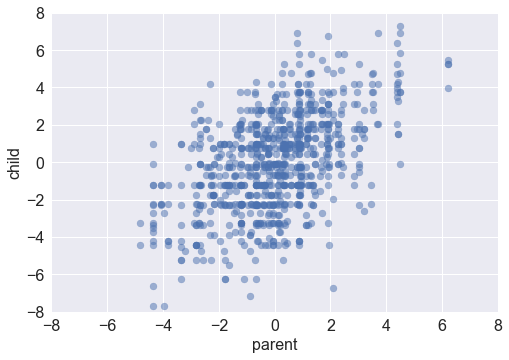

In [5]:
X = galton['Mid-parent centered']
Y = galton['Height centered']

plt.scatter(X, Y, alpha = 0.5)
plt.xlim((-8, 8))
plt.ylim((-8, 8))
plt.xlabel('parent')
plt.ylabel('child')
plt.show()  

This already looks like Galton's graph.  It's pretty clear that the trend is that taller parents have taller children and vice versa.  We still need to show that for every inch of parents' height, a child is expected to gain less than an inch of height.

The last, by the way, is important.  We posit that the relationship is linear: that is, if the parents' height is two inches above average, we expect the child's height will be twice as much above average, compared to the child of parents who are only one inch above average.  To write this as a formula, y = x * w.  Here w is the multiplier, called weight; it is the slope of this line.  It's pretty clear from the picture that the weight is positive.  We will need to compute it to show that it's less than one.

What we need is to draw the line that best approximates the child's height's dependence on parents' height.  And as soon as we've said "best", we know we'll need to measure how well we are doing - or, to be precise, how badly we are doing.  For this, I need to introduce three concepts: hypothesis, error, and loss.

## Hypothesis

$H = X \cdot w$

## Error

$Error = H - Y$

Let's assume we have a parents' centered height x.  We are required to predict the child's centered height, and we posit that the relationship is linear.  That's easy enough: our prediction - called the hypothesis - is x times w.  We don't know what w is, yet.

Notice that H and X are capitalized in this formula.  This is because it's much more efficient - both for the formula readability and for the code performance - to operate with more than one data point at a time.  We store all values of x in one data structure - called a vector - and then multiply this vector by the scalar weight.  Scalar multiplication simply means that each value in the vector gets multiplied by the same value, in this case w.  Then we have a vector of children heights.

What's next?  If we know both the hypothesis and the actual child's height for every data point - this height is our label - then we know by how much we're off; this is our error.  We have a hypothesis and an error for every row of our data, so we can use vectors.  Subtraction here is elementwise; the label, the hypothesis, and the error are all vectors of the same length.

Next, I would like to combine all of these errors - we have a whole vector of errors - and see how much off we are on average.  This is called loss.  We need to come up with a formula that computes loss.  Let's discuss the properties of such formula.

First, I posit that loss should not depend on the sign of the error: a hypothesis five inches over the correct height is as bad as five inches under.  Second, loss should be sensitive to outliers: the bigger the error is, the more penalty should it contribute.  Two inches off shouldn't be twice as bad as one inch off; it should contribute more.  Finally, it should average over all values of the error vector.  Here's one simple formula that has all the requirements.

## Loss

$Loss = \frac{\overline{Error^2}}{2}$

This formula for the loss is called mean square error.  Because of the square, the sign of the error does not matter.  Also because of the square, large errors - which we'd like to avoid - contribute disproportionately to the loss.  The line on top simply means the average.

Notice the one half multiplier.  This two in the denominator is remarkable.  It is simultaneously the least important part of all these lectures, and also the most important.  It is unimportant, because all it does is making one formula further on a tiny bit simpler.  It is also essential because it illustrates the grand philosophical principle that deep learning is built on.  We'll get to that soon.  Don't forget this two in the denominator.

Let me rewrite these three formulae in Python, still working with vectors as much as possible.

In [6]:
def hypothesis(X, w):
    return X * w

def error(X, Y, w):
    return hypothesis(X, w) - Y

def loss(X, Y, w):
    err = error(X, Y, w)
    return err.dot(err) / len(err) / 2 # dot product performs pairwise multiplication and sums the results

Here's the code.  All straightforward: hypothesis, error, loss.  Note that uppercase letters X and Y denote vectors.  Hypothesis uses scalar product.  Error does element-wise subtraction.  Loss uses dot product to compute efficiently - essentialy, the sum of squares of the error vector, divided by its length to get the average.

Let's plot the loss function to see how it depends on weight.

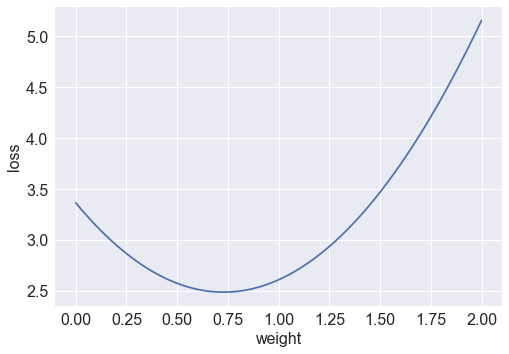

In [7]:
def plot_function(f, x_min, x_max, x_label, y_label):
    x_range = np.linspace(x_min, x_max, 100)
    plt.plot(x_range, list(map(f, x_range)))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

plot_function(lambda w: loss(X, Y, w), 0.0, 2.0, 'weight', 'loss')

This is already useful.  We see that the line that best expresses dependency between parents' height and child's height has a slope around 0.75, which is less than one.  But it would be nice to find out the value more precisely.

We can, of course, compute the values of loss function for multiple values of w, with, say, one-thousands increment.  This is doable in our case, when we have a few hundreds rows of data.  This will not work so well if we have millions, or billions, of rows.  It will most definitely not work when we have more than one feature, in which case the curve above gets replaced with a multi-dimensional surface.  That, by the way, also prevents us from using binary search.  We need to find the lowest point of the curve more efficiently.

Any guesses how many values of loss do I need to calculate to find the lowest point?  10?  4?  2?  1?

The somewhat surprizing answer is 0.  I am not going to calculate the loss at all.  Instead, I am going to calculate the slope of the loss curve; in other words, its gradient, and I'm going to start by calculating it for one entirely arbitraty weight.  Here's the idea.

![Gradient descent](https://miro.medium.com/max/1142/1*jNyE54fTVOH1203IwYeNEg.png)

https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3

Let's pick a single weight.  Then, for this single weight, I'm going to compute the slope of the loss function at this point.  Positive slope means that if I increase my weight, the loss would increase - and that means that to find the minimum I need to move in the direction of lower weight.  If the slope is negative, then to decrease the loss I need to increase the weight.  This means that whatever the gradient is, I need to move in the opposite direction.  Also, if the gradient is steep, I need to move far to find the minimum.  If it's small, I am probably not too far from the minimum, and therefore don't need to move much.  That means I should change my weight proportionately to the value of the gradient, and with the opposite sign.

Now.  How should we find the gradient?

We can use numerical differentiation: compute the loss for one weight, increase the weight a little bit, compute the loss for that increased weight, then divide the change in loss by the change in weight.  But I already promised that I am not going to compute the loss at all.

Instead of numerical differentiation, I am going to use symbolic differentiation: a process that starts with the formula for the loss, and then produces the formula for the gradient for any arbitrary weight.

## Loss

$Loss = \frac{Error^2}{2} = \frac{1}{2}(H - Y)^2 = \frac{1}{2}(X \cdot W - Y)^2$

Let's start by rewriting our loss expression.  We need to take this formula and convert it to a different formula that shows, instead of the value of the function, the slope of the function in respect to W.  In other words, keeping X and Y constant, if I change W a little bit, by how much will the loss change?

### A few shortcuts for symbolic differentiation

$\frac{d(f(x) + c)}{dx} = \frac{df(x)}{dx}$
<br>
$\frac{d(c \cdot f(x))}{dx} = c \cdot \frac{df(x)}{dx}$
<br>
$\frac{dx^n}{dx} = n \cdot x^{n-1}$
<br>
$\frac{d(f(g(x))}{dx} = \frac{d(f(g(x))}{dg(x)} \cdot \frac{d(g(x))}{dx}$

If you haven't done any symbolic differentiation lately, it's considerably easier than you might recall. All you need to know that there are few shortcuts you can apply until the formula is simple enough for your needs. For example, adding a constant does not change the derivative. Multiplying a formula by a constant has the effect of multiplying the derivative by the same constant. The derivative of a X squared is two X. The derivate of a function inside another function is the product of derivatives (the so-called chain rule). 

### Gradient formula for Mean Square Error

$\frac{dL}{dW} = \frac{1}{2}\frac{d(X \cdot W - Y)^2}{dW} = \frac{1}{2}\frac{d(X \cdot W - Y)^2}{d(X \cdot W - Y)}\frac{d(X \cdot W - Y)}{dW} = \frac{1}{2} \cdot 2 \cdot (X \cdot W - Y) \cdot X = Error \cdot X$

Here, I start by moving the constant outside of the differentiation.  Then I apply the chain rule.  The first multiplicand gets simplified using the X squared rule.  The second one gets simplified using the rule about adding and multiplying by a constant.  At the end, the formula for the gradient of our loss is error times X.

Notice that the one half constant was cancelled.  This was the reason that multiplier was there to begin with - for it to get cancelled when we compute the derivative of the loss function.

This is, as I've said before, both elementary and profound.  The elementary aspect is that the multiplier was there only to make the gradient formula simpler.  The profound reason is this.  There is literally an infinite amount of formulae that satisfy our other requirements: larger contributions from ourliers, not dependent on the sign.  Why did we pick the formula we did?

Because it is easy to differntiate.

We will be using other formulae for loss in the future, and we will come back to this point again and again.  Why are we using a particular loss formula?  Not because there is some deep connection between the formula and the way computers, or humans, learn.  No: because this formula is easy to compute the derivate of and gives us the simple formula for the gradient.

Let's translate this into code.

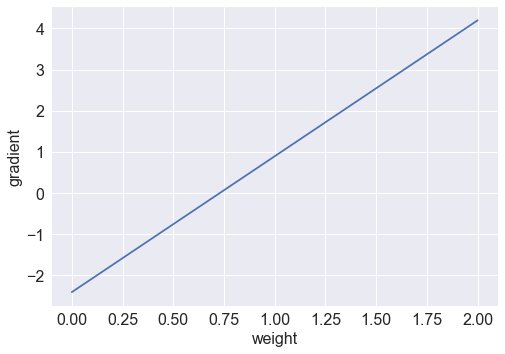

In [8]:
def gradient(X, Y, w):
    return error(X, Y, w).dot(X) / len(X)

plot_function(lambda w: gradient(X, Y, w), 0.0, 2.0, 'weight', 'gradient')

This makes perfect sense: our loss fuction starts steeply negative, then hits a zero gradient point at the minimum, which is around 0.75, then starts growing as the slope increases to the right.  All we need to do is run gradient descent for a few iterations, which are called epochs.

In [9]:
def gradient_descent(X, Y, w, epochs, learning_rate):
    for _ in range(epochs):
        w = w - learning_rate * gradient(X, Y, w)
    return w

In [10]:
EPOCHS = 25
w = gradient_descent(X, Y, 0, EPOCHS, 0.1)
print('w = {:.4f}'.format(w))

w = 0.7287


Here's our answer, after 25 epochs: for each inch of change of parents' average height, child gains about 0.73 inches.  

Now, you might have a couple of questions about the values of the paramertes I used: why did I pick these values for the number of epochs and for the learning rate? Let me plot how the weight w and the average loss change every iteration.  For this, I'm going to rewrite my gradient descent code to keep track of intermediate values.

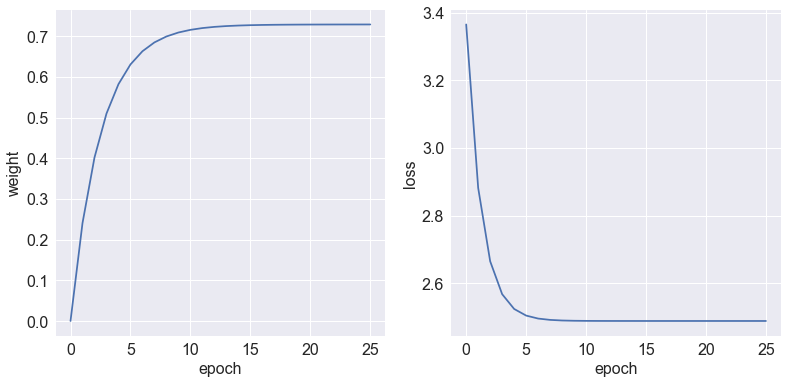

In [11]:
def gradient_descent_with_tracking(X, Y, w, epochs, learning_rate):
    w_list, loss_list = [w], [loss(X, Y, w)]
    for i in range(epochs):
        w = w - learning_rate * gradient(X, Y, w)
        w_list.append(w)
        loss_list.append(loss(X, Y, w))
    return w_list, loss_list

w_list, loss_list = gradient_descent_with_tracking(X, Y, 0, EPOCHS, 0.1)

plt.figure(figsize = (13, 6))
for data, label, plot in [w_list, 'weight', 1], [loss_list, 'loss', 2]:
    pix = plt.subplot(1, 2, plot)
    pix.plot(range(EPOCHS + 1), data)
    pix.set_xlabel('epoch')
    pix.set_ylabel(label)

plt.show()


Notice how the weight increases until it converges, while loss keeps decreasing.  The loss does not converge to zero because a perfect linear fit is impossible.  From these graphs, you can see that all we needed was about 13 iterations.

The next question is, how did I pick the learning rate?  Let me recreate the same couple of plots for three different learning rates.

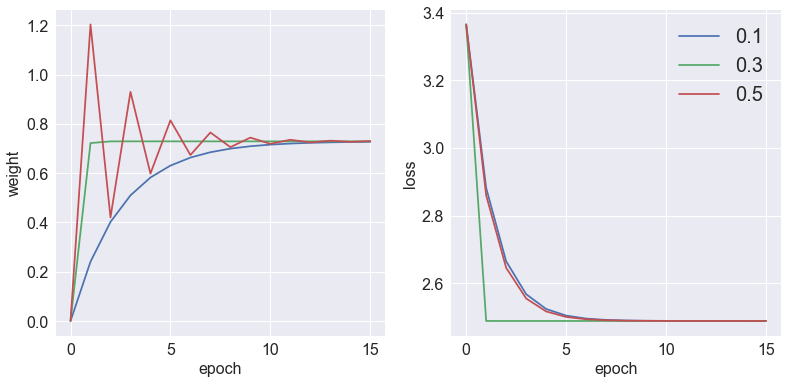

In [12]:
learning_rates = [0.1, 0.3, 0.5]
EPOCHS = 15
plt.figure(figsize = (13, 6))
for learning_rate in learning_rates:
    w_list, loss_list = gradient_descent_with_tracking(X, Y, 0, EPOCHS, learning_rate)
    for data, label, plot in [w_list, 'weight', 1], [loss_list, 'loss', 2]:
        pix = plt.subplot(1, 2, plot)
        pix.plot(range(EPOCHS + 1), data)
        pix.set_xlabel('epoch')
        pix.set_ylabel(label)

plt.legend(learning_rates, loc = 'upper right', fontsize = 20)
plt.show()

Notice how the low learning rate - here in blue - made gradient descent converge slowly; the best learning rate - here in green - made it converge quickly; and the high learning rate made it converge slowly while oscillating, because the value of w overshoots the minimum and has to go back and forth like a pendulim.  What happens if I crank up the learning rate even higher?  Let me plot this data in a slightly different way.

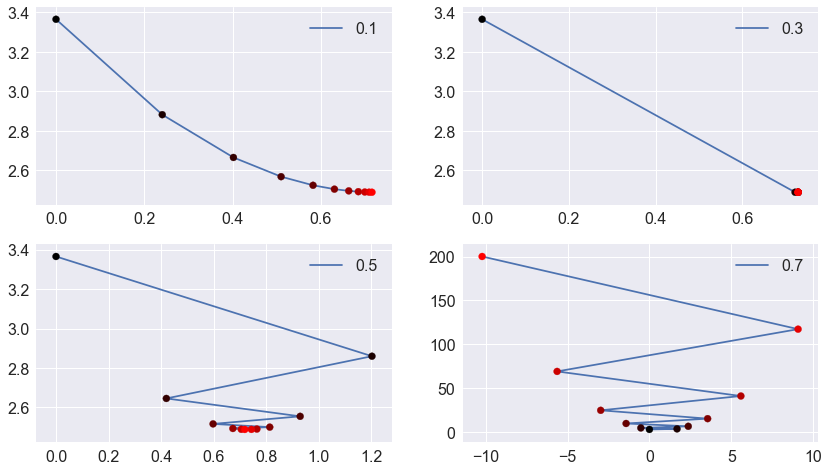

In [13]:
EPOCHS = 10
red_palette = [(red, 0, 0) for red in np.linspace(0.0, 1.0, EPOCHS + 1)]
plt.figure(figsize = (14, 8))
for plot, learning_rate in enumerate([0.1, 0.3, 0.5, 0.7]):
    w_range, loss_range = gradient_descent_with_tracking(X, Y, 0, EPOCHS, learning_rate)
    pix = plt.subplot(2, 2, plot + 1)
    pix.plot(w_range, loss_range, zorder = 1)
    pix.scatter(w_range, loss_range, color = red_palette, zorder = 2)
    pix.legend([learning_rate], loc = 'upper right', fontsize = 16)

plt.show()

Here, I'm plotting weight on the X axis and loss on the Y axis; notice how the points trace the loss function plot.  Early iterations are in black, with the later iterations fading into red.  For the way-too-high learning rate, gradient descent does not converge at all.  If you see your weights oscillating during gradient descent, your learning rate is too high.  If it diverges, it's way too high.

I think we got all the value from Galton's data; let's move to another data set.

## 1993 Breakfast Cereal Manufacturers Association data

http://lib.stat.cmu.edu/datasets/1993.expo/cereal

http://lib.stat.cmu.edu/datasets/1993.expo/    

In [14]:
FEATURES = ['fat', 'protein', 'carb', 'sugar']
LABEL = 'calories'
cereal = pd.read_csv('http://lib.stat.cmu.edu/datasets/1993.expo/cereal', sep = ' ',
                     names = ['name', 'manufacturer', 'type', 'calories', 'protein',
                              'fat', 'sodium', 'fiber', 'carb', 'sugar', 'shelf',
                              'potassium', 'vitamins', 'weight', 'cups'],
                     usecols = ['name', LABEL] + FEATURES)

print(cereal.head(10))

# Missing values are denoted with -1; in this case, we can simply set them to 0
X = np.maximum(cereal[FEATURES].values, 0)
Y = cereal[LABEL].values

                        name  calories  protein  fat  carb  sugar
0                  100%_Bran        70        4    1   5.0      6
1          100%_Natural_Bran       120        3    5   8.0      8
2                   All-Bran        70        4    1   7.0      5
3  All-Bran_with_Extra_Fiber        50        4    0   8.0      0
4             Almond_Delight       110        2    2  14.0      8
5    Apple_Cinnamon_Cheerios       110        2    2  10.5     10
6                Apple_Jacks       110        2    0  11.0     14
7                    Basic_4       130        3    2  18.0      8
8                  Bran_Chex        90        2    1  15.0      6
9                Bran_Flakes        90        3    0  13.0      5


This data is from Breakfast Cereal Manufacturers Association, year 1993.  There's ton of interesting stuff here, including caloric information, amounts of fats, proteins, complex and refined carbohydrates, serving sizes, etcetera.  What I am interested is this.  Measuring caloric content of food is difficult: it involves burning a precisely-measured sample of food under carefully-controlled conditions.  Wouldn't it be nice if we could predict caloric content of cereal from knowing what went into it?  I'm going to assume - because I know - that vitamins and sodium do not contribute calories, and will be looking at four features only, amounts of fats, proteins, and two kinds of carbs.  I will also assume that the relationship is both linear - twice as much protein would add twice as many calories - and additive - meaning we need to add calories from all four columns to get the total.  And this means our data is no longer in a one-dimensional vector, but in a table - properly called a matrix.  Also, instead of one weight, we have a whole vector of weights.  To get the calories, we need to multiply the first feature by the first weight, second feature by the second weight, etc., and when we are done, sum the results for each row.

Fortunately, there is a single operation that does exactly that.  It's called matrix product.

## Matrix product

![Matrix product](https://hadrienj.github.io/assets/images/2.2/dot-product.png)

https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.2-Multiplying-Matrices-and-Vectors/

Here is a picture that shows how it works.  The first multiplicand is the matrix; think of it as our features.  The second one is a vector; think of it as our weights.  The features in the first, blue, column are multiplied by the first, blue, weight G; the features in the second, orange, column are multiplied by the second, orange, weight H.  Then they are summed for each row, and we get a vector, which is our hypothesis.

This looks like it will require a good deal of careful coding.  Good thing Python defines an operator for that.

In [15]:
# Used to be X * w; the @ operator requires NumPy to have been imported
def hypothesis(X, W):
    return X @ W

So far, so good - one character change.  What we need to do now is to compute the gradient of the loss function separately for each weight: what is the gradient relative to the w-protein? what is the gradient relative to w-fat?  Etc.  What do we need to change to compute all of that?

![Gradient descent in more than one dimension](https://www.learnopencv.com/wp-content/uploads/2017/10/gradient-descent-2d-diagram.png)

https://www.learnopencv.com/understanding-activation-functions-in-deep-learning/

The answer is: nothing.  Numpy dot operator automatically performs matrix multiplication when called with matrix arguments, so our gradient function returns a vector with the same shape as weights.  We're good to do.

In [16]:
W = gradient_descent(cereal[FEATURES].values, Y, np.zeros(4), 5000, 0.005)
for feature, weight in zip(FEATURES, W):
    print(feature, round(weight, 3), sep = '\t')

fat	9.138
protein	6.541
carb	3.72
sugar	3.786


This tells us that one gram of fat contributes nine calories, one gram of protein contributes six, and one gram of carbs, whether refined or not, contributes four.  This is incorrect for protein - if you look up caloric content of proteins, you will find that one gram of protein contributes four grams, not six - but it's correct for the three other numbers.  I blame the small data set and the fact that all calories end on a zero, meaning they have been rounded.  But this is a remarkably accurate result in three out of four cases.

In case of a single feature, we were able to look at how weights converge, and how this convergence is affected by learning rate.  We can investigate the same in the case of multiple features.  I cannot really draw a five-dimensional surface with four features and a loss function value, but I can draw a topographic map for two features.  Let's look at the two carbohydrate features.

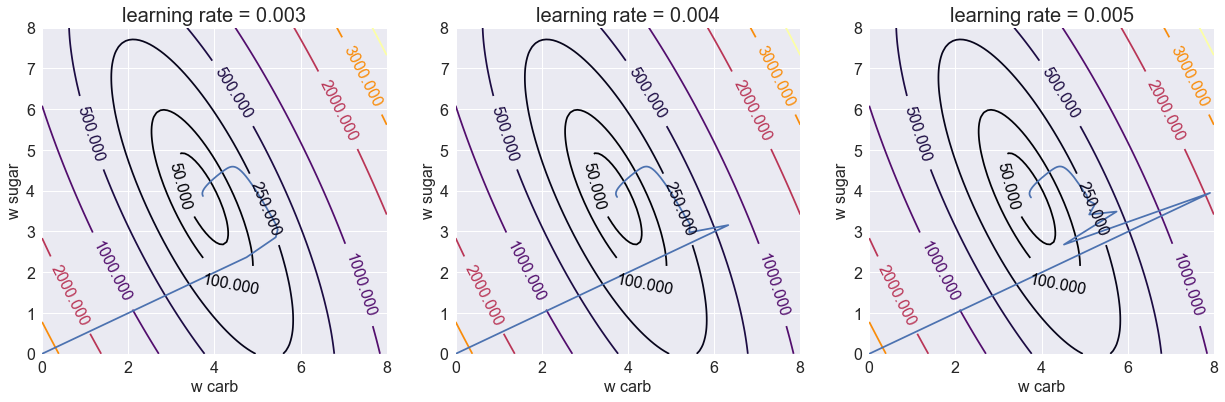

In [17]:
grid = np.linspace(0, 8, 100)
loss_array = [[loss(X, Y, np.array([W[0], W[1], x, y])) for x in grid] for y in grid]
plt.figure(figsize = (21, 6))
for plot, learning_rate in enumerate([0.003, 0.004, 0.005]):
    w_list, _ = gradient_descent_with_tracking(X, Y, np.zeros(4), 1000, learning_rate)
    pix = plt.subplot(1, 3, plot + 1)
    contour = pix.contour(*np.meshgrid(grid, grid), loss_array, cmap = 'inferno', zorder = 1,
                          levels = [50, 100, 250, 500, 1000, 2000, 3000, 4000])
    pix.clabel(contour, inline = 1, fontsize = 16)
    pix.plot([W_history[2] for W_history in w_list], [W_history[3] for W_history in w_list], zorder = 2)
    pix.set_title('learning rate = {}'.format(learning_rate), fontsize = 20)
    pix.set_xlabel('w carb')
    pix.set_ylabel('w sugar')
plt.show()

Notice how the gradient descent converges: a smooth line for low learning rate, an initial overshot for higher one, and some turbulence for the higher one.  But it does converge to the same value: 4 and 4.  When we are dealing with neural networks, we'll be using a more complicated form of a gradient descent, called gradient descent with momentum, which computes the gradient, and then averages it with the gradients of the few previous steps.  In that case, such trajectories do look like you took a ball and rolled it down the slope, and thata does converge faster.  But for our present purposes standard gradient descent is enough.

All right.  Let me switch to yet another data set and make our task more complicated.

In [18]:
from sklearn.datasets import load_boston
boston = load_boston()
# Data set description is in boston.DESCR; labels (house values) are in boston.target
bos = pd.DataFrame(boston.data, columns = boston.feature_names)
bos['Median_price(k)'] = boston.target
print(bos.head(10))

    CRIM    ZN  INDUS  CHAS    NOX     RM    AGE    DIS  RAD    TAX  PTRATIO       B  LSTAT  Median_price(k)
0  0.006  18.0   2.31   0.0  0.538  6.575   65.2  4.090  1.0  296.0     15.3  396.90   4.98             24.0
1  0.027   0.0   7.07   0.0  0.469  6.421   78.9  4.967  2.0  242.0     17.8  396.90   9.14             21.6
2  0.027   0.0   7.07   0.0  0.469  7.185   61.1  4.967  2.0  242.0     17.8  392.83   4.03             34.7
3  0.032   0.0   2.18   0.0  0.458  6.998   45.8  6.062  3.0  222.0     18.7  394.63   2.94             33.4
4  0.069   0.0   2.18   0.0  0.458  7.147   54.2  6.062  3.0  222.0     18.7  396.90   5.33             36.2
5  0.030   0.0   2.18   0.0  0.458  6.430   58.7  6.062  3.0  222.0     18.7  394.12   5.21             28.7
6  0.088  12.5   7.87   0.0  0.524  6.012   66.6  5.561  5.0  311.0     15.2  395.60  12.43             22.9
7  0.145  12.5   7.87   0.0  0.524  6.172   96.1  5.950  5.0  311.0     15.2  396.90  19.15             27.1
8  0.211  12.5   7.

This is the famous 1978 Boston Housing prices data set.  Each row is a census tract in the Metro Boston area, for which multiple variables are recorded, such as crime rate, fraction of the tract zoned for industry, degree of air pollution, average house age, etc.  One can spend weeks with this data set.  I'd like to concentrate on two columns.  One is the feature, which is labeled PTRATIO: an average ratio of pupils to teachers in this tract's public schools.  The dependent variable is the last column, the median house price in thousands - which was obviously quite a bit cheaper in 1978.  I'd like to investigate how the feature affects my label.

Nw, it would make no sense to assume that the house price equals pupil-to-teacher ratio times some weight.  It would make much more sense to assume that there is some ground level house cost in this area, and I would have to pay more for the decrease in the feature (because it's better to have fewer pupils per teacher).  So this changes my formula by introducing a constant, otherwise known as bias.

$Y = b + X \cdot W$

I could do something like what Galton did, and center the data by subtracting the average value, but I wonder if I could asvoid doing that.  I would like my regression to tell me both values: bias and weight (or weights, if I have multiple features).  Given that it took us one character to adapt the code to return a weight vector as opposed to a single scalar weight, any guesses on how much I need to change the code to also produce bias?

The answer is, naturally, not at all.  I'm not going to modify the code.  I'm going to modify the data.

In [19]:
X = bos[['PTRATIO']]
X['bias'] = 1
print(X.head(10))

   PTRATIO  bias
0     15.3     1
1     17.8     1
2     17.8     1
3     18.7     1
4     18.7     1
5     18.7     1
6     15.2     1
7     15.2     1
8     15.2     1
9     15.2     1


I've added a new column to my data set, and populated it entirely with ones.  Now, when I run regression on this two-feature data set, linear regression will give me the weight for the first feature, as well as the weight for the second feature.  Since this second weight multiplies the column which entirely consists of ones, this second weight will be my bias.

In [20]:
W = gradient_descent(X.values, boston.target, np.zeros(2), 100000, 0.005)
print(np.round(W, 3), '\n')
for ptratio in [min(X['PTRATIO']), max(X['PTRATIO'])]:
    print(ptratio, round(ptratio * W[0] + W[1], 3))

[-2.153 62.272] 

12.6 35.141
22.0 14.9


So you see that a house in a town with the lowest pupil-to-teacher ratio - again, ignoring other columns - would cost more than twice than the house with the highest ratio.  For every extra student per teacher, the house will be more than two thousand dollars cheaper.

You think we've done a lot.  Oh, we are just starting.  I'm not going to touch my gradient descent code any more today.  But if all you have is a hammer, everything looks like a nail.   Let us find a few more nails.

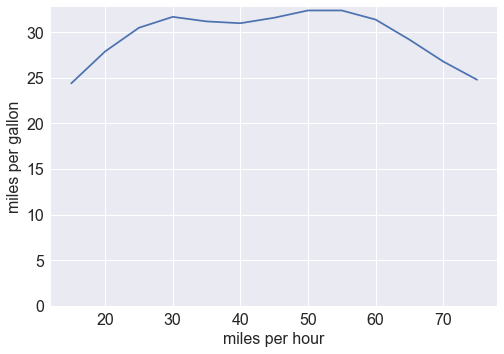

In [21]:
# Averege MPG vs. speed for 1997 cars and light trucks, from
# the table 4.29 of https://cta.ornl.gov/data/chapter4.shtml

car_x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
car_y = [24.4, 27.9, 30.5, 31.7, 31.2, 31.0, 31.6, 32.4, 32.4, 31.4, 29.2, 26.8, 24.8]
plt.plot(car_x, car_y)
plt.ylim(bottom = 0.0)
plt.xlabel('miles per hour')
plt.ylabel('miles per gallon')
plt.show()

This is a small data set that it was easier for me to enter by hand than to try to write code that connects to a secure government web page, downloads a Microsoft Excel file in a no-longer-supported-by-Microsoft format, parses it, and then extracts table 29 from sheet 4.

Anyway.  This is miles-per-gallon fuel consumption for cars and light trucks in 1997.  The X axis is car speed.  I want to determine the optimal speed: how fast do I need to drive, in my 1997 car, to get the best fuel economy.  For the purposes of this discussion, let's assume I'm the top expert on all things car.

Now, there are a few problems with this data.  First, there is this concave area in the middle, which I declare does not make sense, should not be there, and is due to some measurement error.  Second, the data is collected for every 5 miles-per-hour increment, and that's not accurate enough for me.  Can I fit this curve using my linear regression algorithm?

Now, this dependence is clearly not linear - the whole point is that I want to find the best mileage.  If I just run linear regression on this data, asking for weight and bias, the algorithm will produce a straight line, which will tell me that to get the best fuel economy I need to either drive infinitely fast, or else stand still, which are both ridiculous.

Let's go back to the previous problem we've solved, where we introduced a constant by appending a column of ones.  It so happens that any number to the power of zero is one, so you can think of bias as simply the feature to the power of zero.  Well, if I can raise the feature to the power of zero, nothing stops me from raising it to other powers.  As a matter of fact, I'm going to write a helper function that replicates the feature as many times as I need, raising it to the powers of zero, one, two - as high as I need.

In [22]:
def polynomial(X, power_max):
    return np.array([np.power(X, p) for p in range(power_max + 1)]).T

polynomial([1, 2, 3], 3)

array([[ 1,  1,  1,  1],
       [ 1,  2,  4,  8],
       [ 1,  3,  9, 27]])

Here we take the feature vector, raise it to a whole range of powers, and stack the results as columns into a matrix.  In this example, the first column is the feature to the power of zero, then the feature itself, then feature squared, then cubed.  Since my data - miles per gallon vs. miles per hour - looks like a parabola upside down, I'm going to model it as a quadratic dependency.

In [23]:
car_x2 = polynomial(car_x, 2)
car_x2

array([[   1,   15,  225],
       [   1,   20,  400],
       [   1,   25,  625],
       [   1,   30,  900],
       [   1,   35, 1225],
       [   1,   40, 1600],
       [   1,   45, 2025],
       [   1,   50, 2500],
       [   1,   55, 3025],
       [   1,   60, 3600],
       [   1,   65, 4225],
       [   1,   70, 4900],
       [   1,   75, 5625]])

Here we go: from one feature we made three: bias, original feature, and the feature squared.  What would happen if I ran gradient descent on this data?

In [24]:
RUN = False
if RUN:
    print(gradient_descent(car_x2, car_y, np.zeros(3), 1000000, 0.0000002))

The answer is: nothing good.  There is a huge variation in magnitude between the columns, meaning the loss function slope is shallow very for the feature and extremely steep the feature squared.  If I pick a large learning rate, I will run into overflows, and if I pick a small learning rate, it will take literally tens of millions of iterations before I converge.  Since I promised no more gradient descent code, I'm not going to fix the code.  I'm going to fix the features.  What I will do is normalize the data, by dividing the values in each column by this column's average.

In [25]:
car_x2_scale = car_x2.mean(axis = 0)
car_x2_scaled = car_x2 / car_x2_scale
print(car_x2_scale, np.round(car_x2_scaled, 3), sep = '\n\n')

[1.000e+00 4.500e+01 2.375e+03]

[[1.    0.333 0.095]
 [1.    0.444 0.168]
 [1.    0.556 0.263]
 [1.    0.667 0.379]
 [1.    0.778 0.516]
 [1.    0.889 0.674]
 [1.    1.    0.853]
 [1.    1.111 1.053]
 [1.    1.222 1.274]
 [1.    1.333 1.516]
 [1.    1.444 1.779]
 [1.    1.556 2.063]
 [1.    1.667 2.368]]


Here, I simply divide each column by the average of all the values in this column.  The bias remains one; the other two columns fit a much more similar range between zero and approximately two.  There are multiple ways to normalize data: in the literature, you will see a more elaborate suggestion of first subtracting the average value of the column and then dividing by standard deviation - but in many cases the approach above is quite sufficient.

Now we can run gradient descent.

In [26]:
W_scaled = gradient_descent(car_x2_scaled, car_y, np.zeros(3), 50000, 0.1)
print(np.round(W_scaled, 3))

[ 16.03   33.282 -19.674]


Notice this does not take tens of millions of iterations.  Now that we have the equation for the fitted second-order polynomial, we can compute the optimum.

Maximum at 44.64


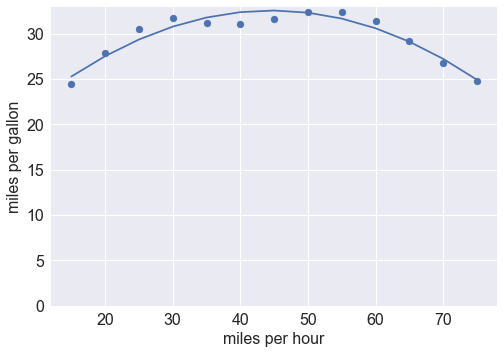

In [27]:
W = W_scaled / car_x2_scale
print('Maximum at {:.2f}'.format(-W[1] / W[2] / 2))

plt.scatter(car_x, car_y)
plt.plot(car_x, hypothesis(car_x2, W))
plt.ylim(bottom = 0.0)
plt.xlabel('miles per hour')
plt.ylabel('miles per gallon')
plt.show()

As you see, you get the best MPG if you drive at about forty-four point six miles an hour.

One more data set - the last one for today.

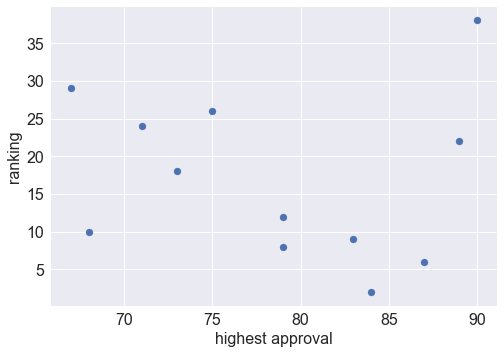

In [28]:
# Data via here: http://statisticsbyjim.com/regression/interpret-adjusted-r-squared-predicted-r-squared-regression/

presidents_approval_high = [67, 68, 71, 73, 75, 79, 79, 83, 84, 87, 89, 90]
presidents_ranking = [29, 10, 24, 18, 26, 8, 12, 9, 2, 6, 22, 38]
plt.scatter(presidents_approval_high, presidents_ranking)
plt.xlabel('highest approval')
plt.ylabel('ranking')
plt.show()

The X axis is the highest approval rating a US president received during his tenure.  The Y axis is the ranking this president receives, among other presidents, from a well-regarded group of historians, after his presidency is over.  The data is for recent presidents only.  It might be clear who is the outlier in the top right corner.

This is clearly a more complicated dependency than we've dealt with before.  But I also know that I need N points to define an order N-1 polynomial.  Since I don't know which one makes the best fit, I'm going to try them all, from power one - meaning the original data and bias - all the way up to the ninth power.  I'll plot the best-fit curve along with the final loss value.

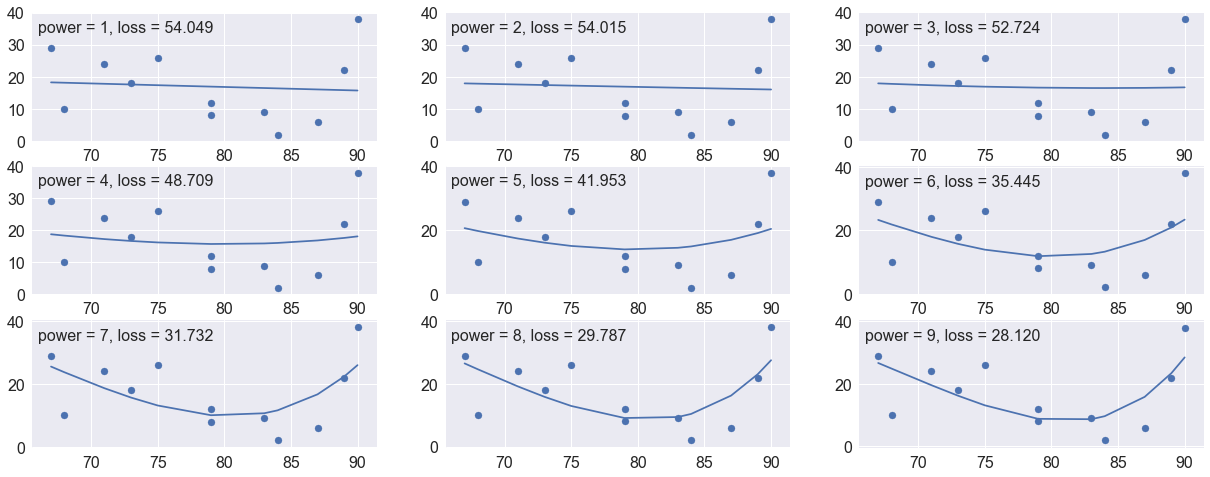

In [29]:
plt.figure(figsize = (21, 8))
for power in range(1, 10):
    X = polynomial(presidents_approval_high, power)
    X_scale = X.mean(axis = 0)
    X_scaled = X / X_scale
    W = gradient_descent(X_scaled, presidents_ranking, np.zeros(power + 1), 10000, 0.1)
    pix = plt.subplot(3, 3, power)
    pix.plot(presidents_approval_high, hypothesis(X_scaled, W))
    pix.scatter(presidents_approval_high, presidents_ranking)
    pix.text(66, 34, 'power = {}, loss = {:.3f}'.format(power, loss(X_scaled, presidents_ranking, W)), fontsize = 16)
plt.show()

Here's the whole grid of results, in all their glory.  Notice how for the low power the fit does not look good and the loss is over fifty - but the more terms we add to the polynomial curve, the better the fit becomes, and the loss at the end is about half of what we started with.

So - excellent, good fit, low loss, well done all around.  There's only one problem with it: it's total nonsense.  It does not make any sense that historians think better of you if your top approval is up to, say, 82, and then they think worse and worse of you.  We can remove the outlier and re-run the analysis, sure, but this is a small data set, with a single feature.  Large or multi-dimensional data sets do not make visual exploration easy.  There should be a way to do this automatically.

For this, we need to take a step back and consider why are we doing all of this.  For all of this talk, I've been concentrating on examining the linear regression models: what the weights are, and what do they mean.  In real life, what you are usually interested in is not a best-line fit of historical data, but inference: a way to predict the label for the previously unseen data.  If we know how tall the parents are, what is the likeliest height of their child?  I just developed a new cereal; what is its caloric value?  Etc.

What I need to know is how well I can predict the data I have not seen before, not the data I've used to train my model.  For this, I am going to split my data into two: one set I will call "training set", and I'm going to to use it as the input to generate my regression weights.  The other set is called "test set", and I will use it to measure the quality of my model, meaning I will compute loss on the data points that my algorithm did not use in training.

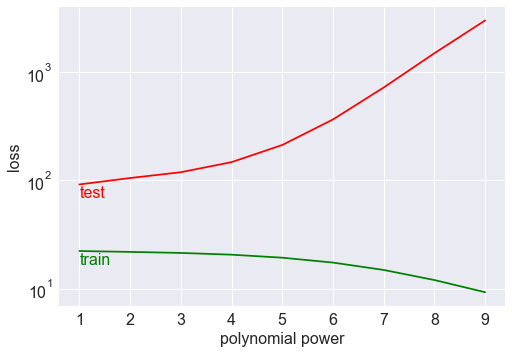

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(presidents_approval_high, presidents_ranking,
                                                    test_size = 0.5, random_state = 10001)

train_loss, test_loss = [], []
for power in range(1, 10):
    X = polynomial(X_train, power)
    X_scale = X.mean(axis = 0)
    X_scaled = X / X_scale
    W = gradient_descent(X_scaled, Y_train, np.zeros(power + 1), 10000, 0.1) / X_scale
    train_loss.append(loss(X, Y_train, W))
    test_loss.append(loss(polynomial(X_test, power), Y_test, W))

for data, label, color in [[train_loss, 'train', 'green'], [test_loss, 'test', 'red']]:
    plt.plot(range(1, 10), data, color = color)
    plt.text(1, data[0] * 0.75, label, fontsize = 16, color = color)

plt.xlabel('polynomial power')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

I don't have much data here - only 12 rows - so I'm splitting it randomly and evenly: half the data points go into the training set, the rest goes into the test set.   Then I obtain the weights from training linear regression on the training set, and compute two losses: one for the training set, and one for the test set.  For training set, as we saw above, the losses decrease as the polynomial power increases.  For test set, we are doing worse and worse.  This is called overfitting: our model expresses the underlying nature of the training set so well that it does not model well the broader pattern of the underlying data, including the data that is not in the training set.  Basically, its gets distraced by noise.  If you are trying multiple variations on your model, pick the one that performs best not on the training set, but on the test set.  In this case, the best model is the linear relationship.

In [31]:
X = polynomial(presidents_approval_high, 1)
X_scale = X.max(axis = 0)
W = gradient_descent(X / X_scale, presidents_ranking, np.zeros(2), 10000, 0.5) / X_scale
print('{:.3f}, {:.3f}'.format(W[0], W[1]))

25.809, -0.112


Here we go, the bias and the weight.  The weight is negative, as expected: the higher the presidential approval is, the better will be the president's position on the historian's list.

There's also a useful rule of thumb I'd like to mention here.  For each weight in your model, it's a good idea to have at least ten rows of data to avoid overfitting.  This tiny data set has twelve rows.  So even the first power polynomial, which produces one weight and a bias, might be already too much to ask from this size set.

Also, with large data sets, you will obviously not need half of your data in the test set.  Use ninety percent of data to train and ten percent to test.  For huge sets - tens of millions of rows - even one percent is sufficient for testing.

For most type of data, random split is fine - unless you have a time dimension in your data.  In that case, since you will need to run inference on future data, split it time-wise: train on older data; test on more recent data.

One more thing.  The plot with two curves - train set loss and test set loss - is a very useful tool, as useful for regression as it is for deep learning and any kind of machine learning.  Normally, when you have more data, it will look like this.

## Train loss and test loss

![Train loss and test loss](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Overfitting_svg.svg/640px-Overfitting_svg.svg.png)

https://en.wikipedia.org/wiki/Overfitting

The Y axis is loss, the blue line is for loss computed on the train set, the red line is for loss computed on the test set (sometimes called validation set).  X axis is your model complexity: adding extra features, or simply training for more epochs.  Notice the two loss curves start similar: simplistic models are bad, whether you apply them to train data or test data.  Eventually, they get better.  After some point, training set loss keeps decreasing while test set loss starts getting worse again.  This is the point where you stop - where you got the best model.

This concludes my introduction to linear regression, other than one small point.  You don't need to update the weights after processing the entire data set; frequently, gradient descent can converge after fewer epochs if you update the weights after processing a smaller batch of training data.  This is called sometimes called batch gradient descent and sometimes stochastic gradient descent, and most libraries will let you adjust the batch size.

Finally, and perhaps most importantly: you do not need to use my code.  Linear regression is implemented in multiple libraries in Python and other languages.  For example, you can use statsmodels.

In [32]:
import statsmodels.api as stats

# See http://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

stats_lin_reg = stats.OLS(
    presidents_ranking,
    stats.add_constant(presidents_approval_high)).fit()
print('{:.3f}, {:.3f}'.format(stats_lin_reg.params[0], stats_lin_reg.params[1]))

25.809, -0.112


Here, the first argument is the label, second argument is the features, and you have to explicitly add the bias column, for which there is a helper function.  The bias and the weight are exactly what we computed before.

In [33]:
from sklearn import linear_model

# See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

scikit_lin_regr = linear_model.LinearRegression().fit(
    np.array(presidents_approval_high).reshape(-1, 1),
    presidents_ranking)

print('{:.3f}, {:.3f}'.format(scikit_lin_regr.intercept_, scikit_lin_regr.coef_[0]))

25.809, -0.112


...or you can use sci-kit, which switches the arguments' order: features first, requiring a matrix, which is why I reshape the vector into a one-column matrix, and labels second.  Sci-kit computes bias by default; it's called intercept here.  The result is the same, naturally.

Finally, you can use TensorFlow.

In [34]:
import tensorflow as tf

x_scale = max(presidents_approval_high)

tf_lin_model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_dim = 1, kernel_initializer = 'zeros')])
tf_lin_model.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.5), loss = 'mean_squared_error')
tf_lin_model.fit(
    np.array(presidents_approval_high) / x_scale,
    np.array(presidents_ranking),
    epochs = 3000, verbose = 0)

W = tf_lin_model.get_layer(index = 0).get_weights()
print('{:.3f}, {:.3f}'.format(W[1].item(), W[0].item() / x_scale))

tf.keras.backend.clear_session()

25.809, -0.112


TensorFlow is hugely powerful and extremely configurable, for which you have to pay with more complex code and slower performance.  Here, I essentially recreate my Python code: Dense layer means I want the linear combination of my inputs, with bias included by default; initialize weights to zero; run gradient descent with the particular learning rate; and use mean squared error loss function.  TensorFlow can even normalize the data for you.  I do that outside of TensorFlow so that I can rescale the weight and show that, yes, it returns the same results.  We'll get to use TensorFlow much more when when get to neural net

Next week, we'll be discussing logistic regression, which means we are going to India to prospect for gold.

Thank you for your attention.